In [130]:
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import time
import sys


def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return np.array((m1,m2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))

'''my Tmodel(considering gas (GeoUnits))'''
def k_1cal(m_1,m_2):
    return 64.0*m_1*m_2*(m_1+m_2)/5.0
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acalgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    a_ft=acalgas(t,m_1,m_2,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt((m_1+m_2)*np.power(a_ft,-3.0))
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,t_gas,t_0,phi):
    return m_1*m_2/acalgas(t,m_1,m_2,t_gas,t_0)*np.cos(phi)

'''my Tmode not considering gas'''
def acalvac(t,m_1,m_2,t_c):
    k_1=k_1cal(m_1,m_2)
    return np.power(4*k_1*(t_c-t),0.25)
def freq_tvac(t,m_1,m_2,t_c):
    avt=acalvac(t,m_1,m_2,t_c)
    return np.sqrt((m_1+m_2))/sciconsts.pi*np.power(avt,-1.5)
def phi_tvac(t,m_1,m_2,t_c):
    cm2=chirp_mass(m_1,m_2)
    return -2*np.power(1.0/5.0/cm2*(t_c-t),5.0/8.0)
def hvac(t,m_1,m_2,t_c,phi_c):
    return  m_1*m_2/acalvac(t,m_1,m_2,t_c)*np.cos(phi_tvac(t,m_1,m_2,t_c)+phi_c)
#phi_c[0,2pi]
def f_jugg(t_c,m_1,m_2):
    return (freq_tvac(0,m_1,m_2,t_c),freq_tvac(4*years,m_1,m_2,t_c))
def t_fvac(f,m_c,t_c):
    return t_c-5*np.power(8.0*sciconsts.pi*f,-8.0/3.0)*np.power(m_c,-5.0/3.0)
def tlimit(m_c,fi,ff):
    sci1=1.0/5.0/m_c
    a=np.array((np.power(8.0*sciconsts.pi*fi/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0),4*years+np.power(8.0*sciconsts.pi*ff/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0)))
    return [a.min(),a.max()]
def tcn_decide(mc,fi,ff,acu):
    return ((tlimit(mc,fi,ff)[1]-tlimit(mc,figas,ffgas)[0])/tlimit(mc,fi,ff)[1])//acu+1
def noden_cal(mc,phinum,tcn_racu,fi,ff):
    mcn=mc.size
    i=0
    sum1=0
    while i<mcn:
        sum1=sum1+tcn_decide(mc[i],fi,ff,tcn_racu)
        i=i+1
    return sum1*phinum


def pow2(a):
    b=1
    i=True
    while i:
        b=2*b
        if b>a:
            i=False
    return b
'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)
fname=sys.argv[0]+'value.txt'
#consts setting
m_sun=1.9891e30/np.power(sciconsts.c,3.0)*sciconsts.G      #c=G=1 mass unit to s
years=365*24*3600.0
#mpc=3.261*sciconsts.light_year#c=G=1 mass unit to s
mpc=3.261*years*1e6
t_scale=4*years
#gas cal
n=10.0
m_1g=n*m_sun
m_2g=n*m_sun
k_1g=k_1cal(m_1g,m_2g)
t_gas=1000.0*years
a_0=3.0e8/sciconsts.c
t_0g=t_0cal(m_1g,m_2g,t_gas,a_0)
#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
Ng=10000000
t=np.linspace(0,t_scale,num=Ng)
#tdomain interp1d
tphi=np.linspace(0,t_scale,10000)
i=0
workphi=np.zeros(10000)
while i<10000:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)
#tdomain point cal
Tg=t_scale/Ng
hfgas=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))
#fft
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfgas1=fft.fft(hfgas)
hfgas_abs=abs(hfgas1)
hfgas_angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
hfgas2=2.0/Ng*hfgas_abs[0:Ng//2]
hs=sci_interpolate.interp1d(xs,hfgas2)
anglegas=sci_interpolate.interp1d(xs,hfgas_angle)
A=sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/S_n_lisa(x),figas,ffgas,limit=1500,epsabs=0.005)
Aval=np.sqrt(A[0])
Aerr=0.5/Aval*A[1]
Aval/(10*mpc),Aerr/(10*mpc)

(3.0660619251770392e-08, 8.7866817161711891e-11)

In [126]:
hfgas2.max()*hfgas2.max()*(ffgas-figas),hfgas.max()*hfgas.max()*4*years/1.414

(6.4559757215681447e-26, 5.2962775644104664e-10)

In [127]:
hfgas2.max(),hfgas.max()

(5.5648651184641841e-11, 2.4365581146158285e-09)

In [109]:
ht=100*m_sun*m_sun/10/mpc/a_0*4

In [116]:
np.sqrt(ht*ht*4*years*4/1.902*1e40)

15.368515012701286

In [107]:
ht*ht*4*years/1.902*1e40

0.0059047813423906198

In [103]:
hfgas2.max()

5.5648651195536915e-11

In [122]:
t=np.linspace(1e-5,0.01,100000)
s=np.zeros(100000)
i=0
while i<100000 :
    s[i]=S_n_lisa(t[i])
    i=i+1

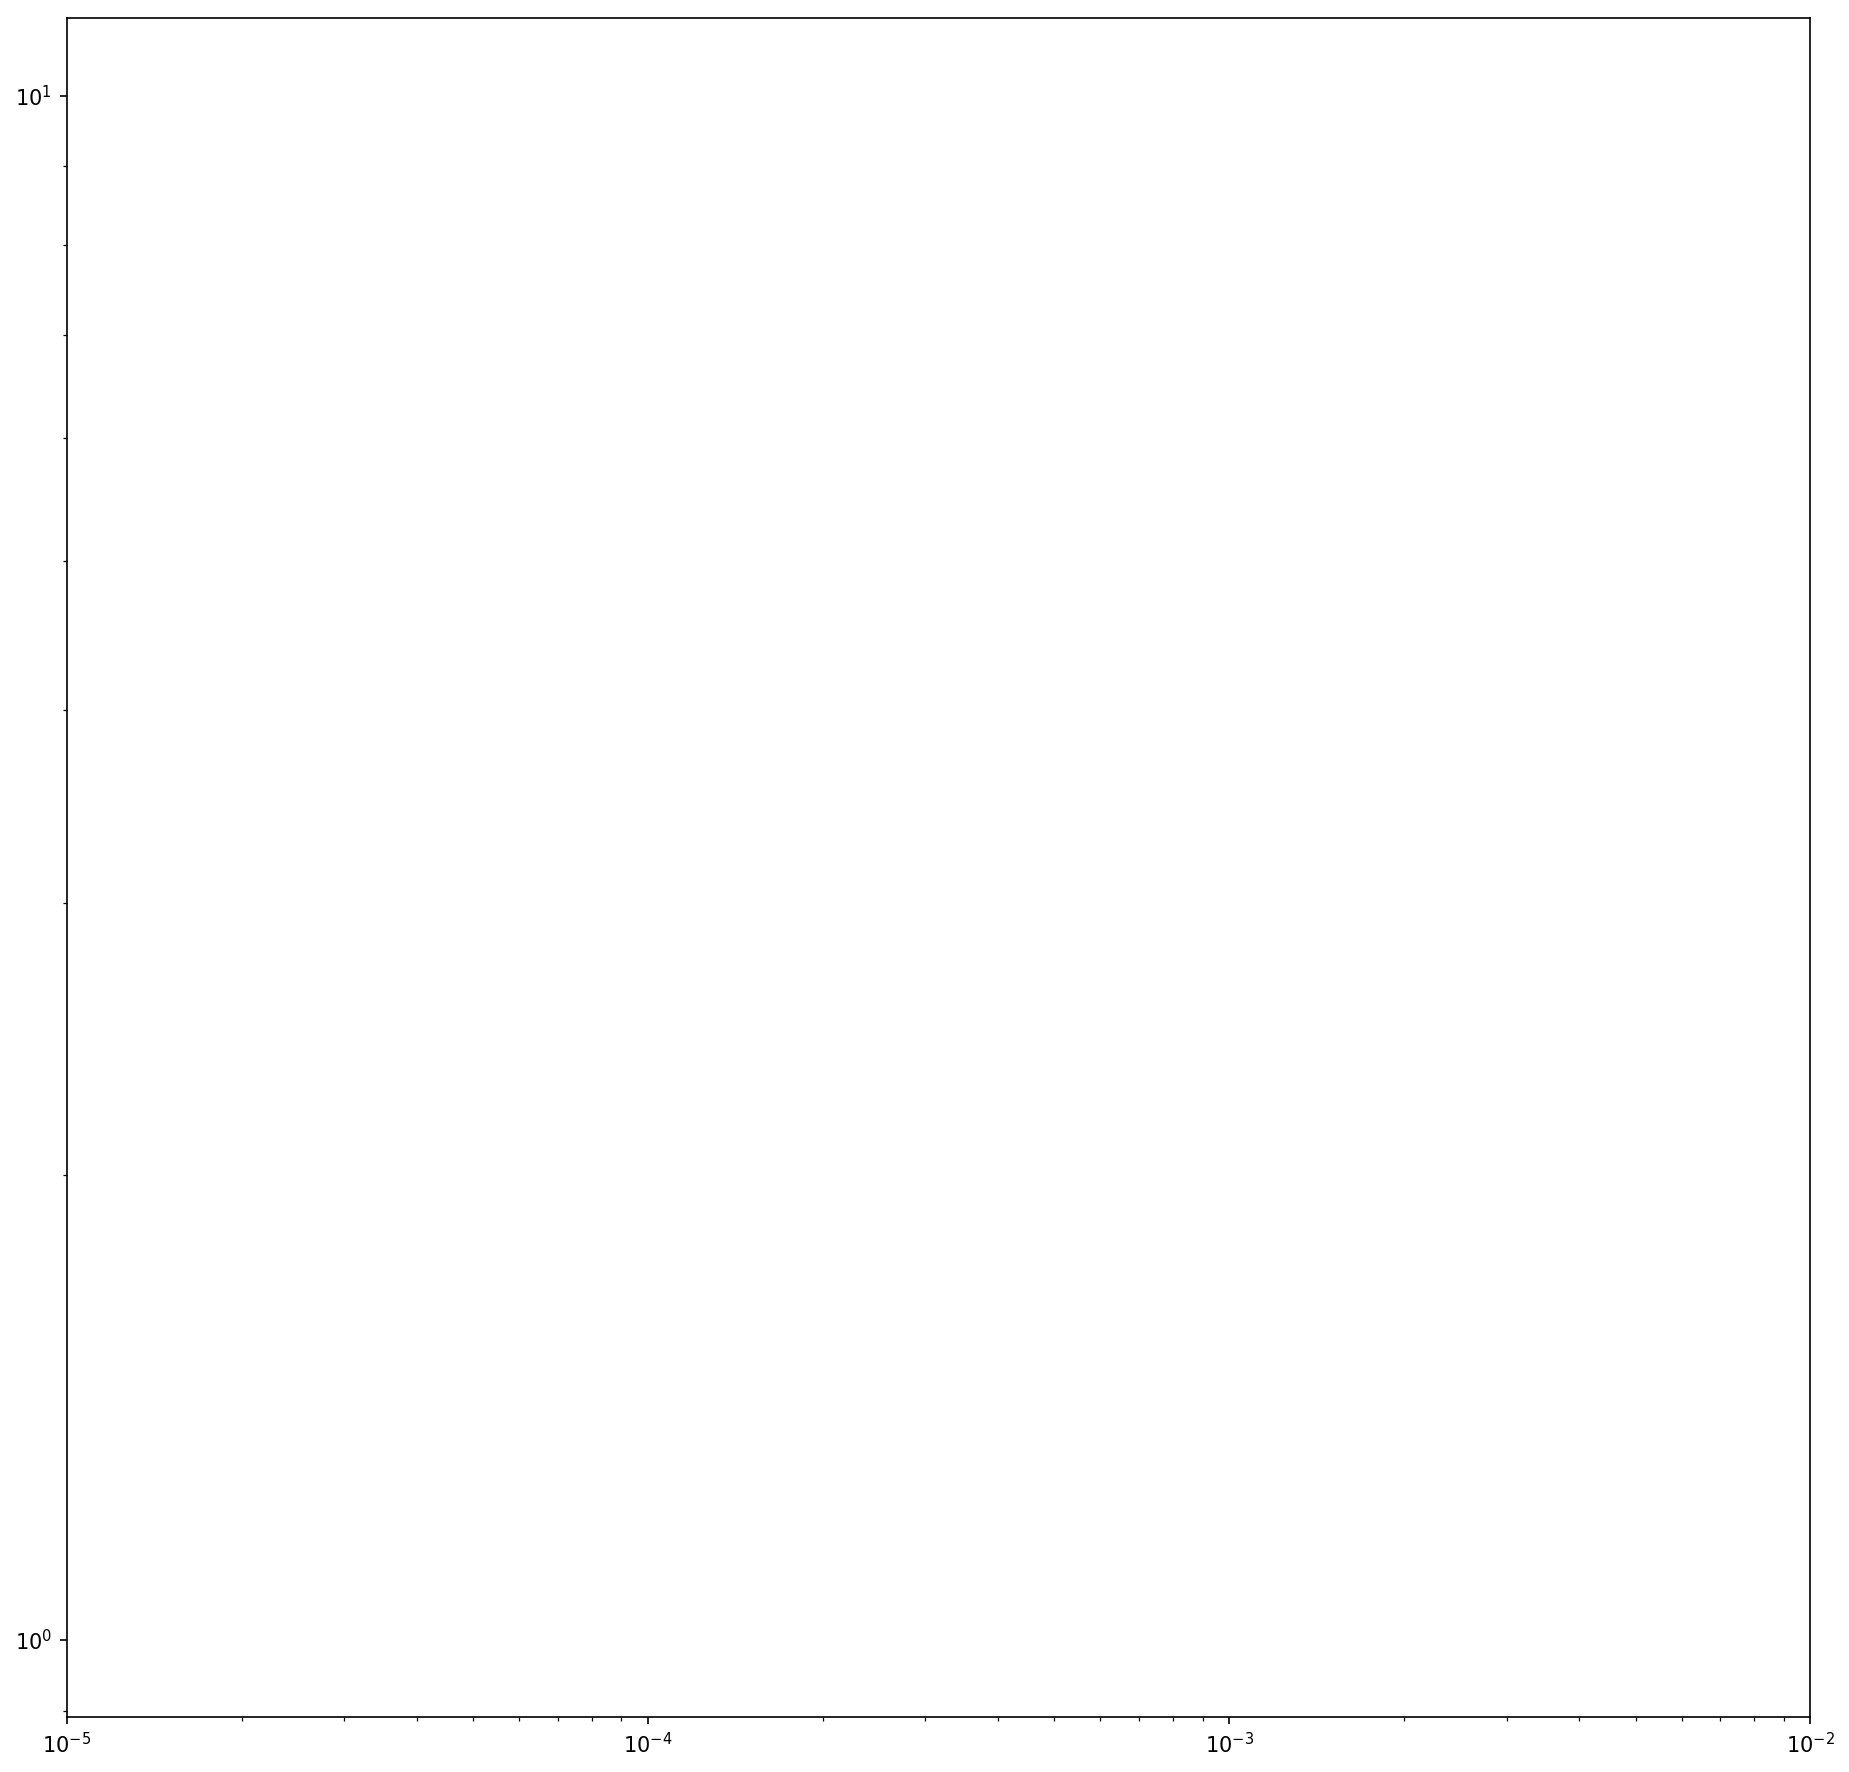

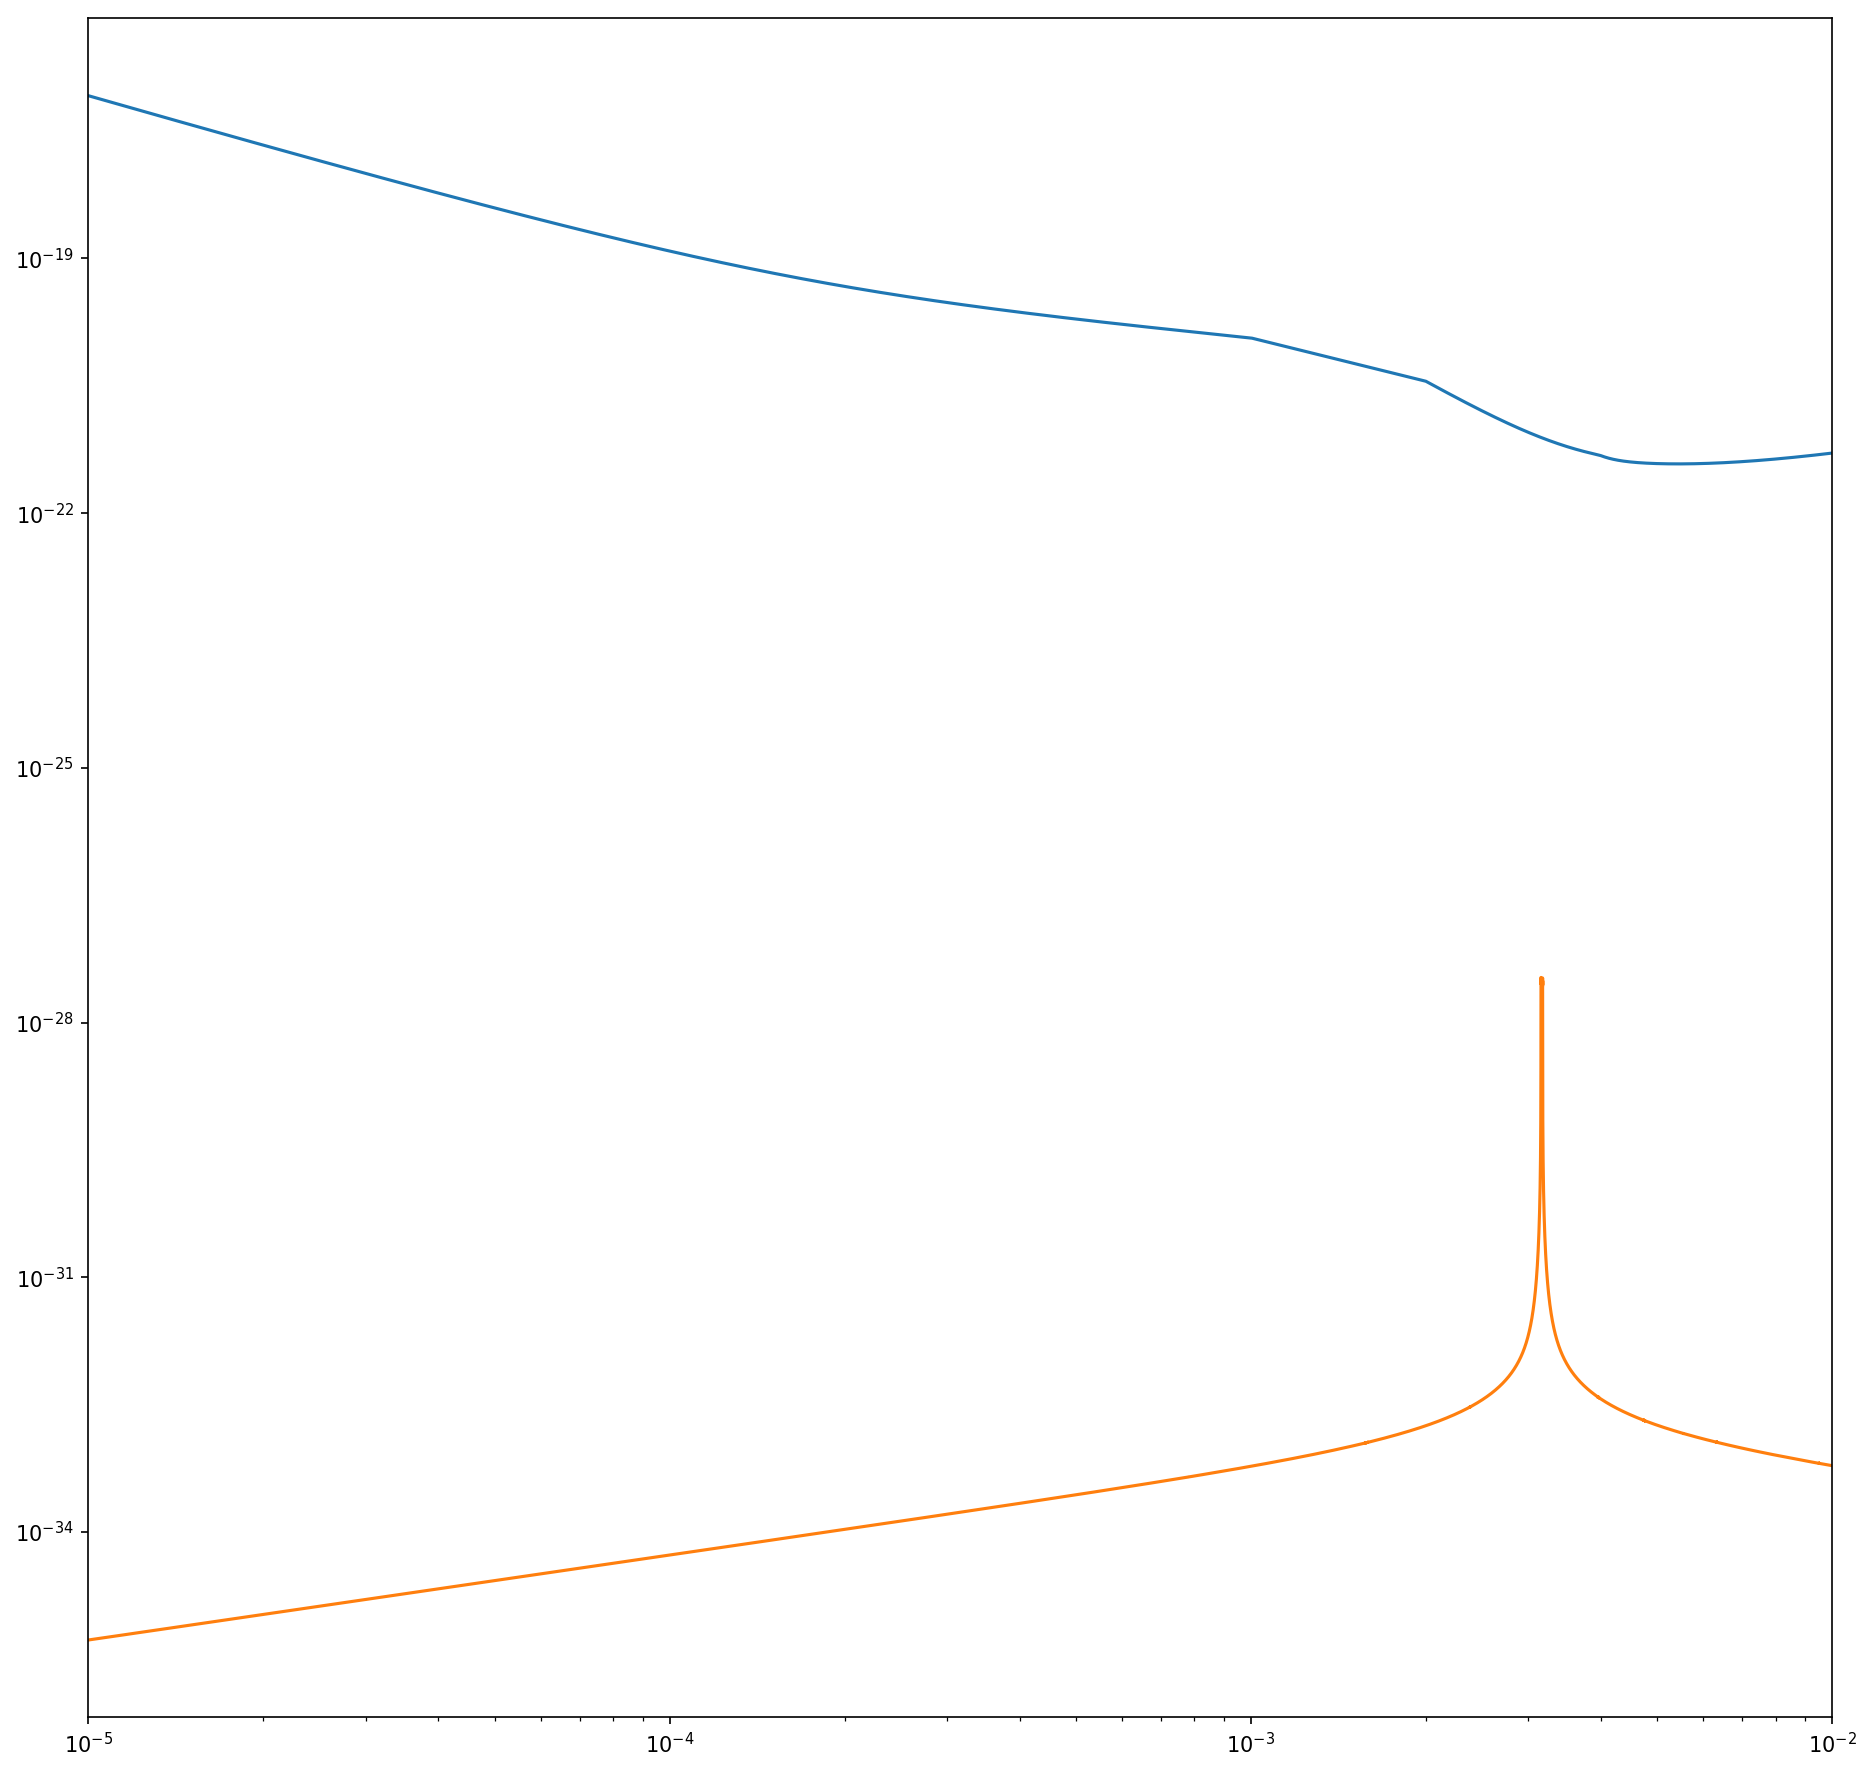

In [123]:
import matplotlib.pyplot as plt
fig1=plt.figure(figsize=(15,15),dpi=150)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-5,0.01)
plt.plot(t,np.sqrt(t*s))
plt.plot(t,2*t*hs(t)/10/mpc)
plt.show()

In [75]:
mcnum=1000
phinum=30
acu=0.0001
mcs=37.2105*m_sun
phis=np.linspace(0,2*sciconsts.pi,phinum)
ffmax=0.0
errmax=0.0
m1v=solvem(mcs,0.25)[0]
m2v=solvem(mcs,0.25)[1]
tcl=tlimit(mcs,figas,ffgas)
tcnum=tcn_decide(mcs,figas,ffgas,acu)
print tcnum
tcl_sp=np.linspace(tcl[0],tcl[1],tcnum)
tcn=0
while tcn<tcnum:
    phin=0
    while phin<phinum:
        ti=time.clock()
        fivac=freq_tvac(0,m1v,m2v,tcl_sp[tcn])
        ffvac=freq_tvac(4*years,m1v,m2v,tcl_sp[tcn])
        Ng=int(t_scale*ffvac*4)
        Ng=pow2(Ng)
        T=t_scale/Ng
        xs=np.linspace(0,1/2.0/T,num=Ng//2)
        t=np.linspace(0,t_scale,num=Ng//2)
        hvt=hvac(t,m1v,m2v,tcl_sp[tcn],phis[phin])
        hfvac1=fft.fft(hvt)
        hfvac_abs=abs(hfvac1)
        hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
        anglevac=sci_interpolate.interp1d(xs,hfvac_angle)
        hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
        hvacs=sci_interpolate.interp1d(xs,hfvac2)
        d=(np.array((fivac,figas)).max(),np.array((ffvac,ffgas)).min())
        B=sci_integrate.quad(lambda x:4*np.power(hvacs(x),2.0)/S_n_lisa(x),fivac,ffvac,limit=1500,epsabs=0.005)
        Bval=np.sqrt(B[0])
        Berr=0.5/Bval*B[1]
        AB=sci_integrate.quad(lambda x:4*hvacs(x)*hs(x)/S_n_lisa(x)*np.cos(anglegas(x)-anglevac(x)),d[0],d[1],limit=1500,epsabs=0.005)
        ff=AB[0]/Aval/Bval
        err=abs(1/Aval/Bval*AB[1])+abs(AB[0]/Aval/Aval/Bval*Aerr)+abs(AB[0]/Aval/Bval/Bval*Berr)
        tf=time.clock()
        if ff>ffmax:
            ffmax=ff
            errmax=err
        print Aval,Bval,AB[0],ff,err
        #sys.stdout.flush()
        phin=phin+1
    tcn=tcn+1
data[mcn,0]=mcs[mcn]/m_sun
data[mcn,1]=ffmax
data[mcn,2]=errmax
print data[mcn,0],data[mcn,1],data[mcn,2]
np.savetxt(fname,data)
te=time.clock()
print 'cal completed!',(te-tb)/3600,'h'
sys.stdout.flush()

1.0
31531042.3453 177542566.899 4.0461328469e+15 0.722768664446 0.00617850645104
31531042.3453 177542543.361 4.0619588844e+15 0.725595796831 0.00359729335537
31531042.3453 177542539.389 3.88802096959e+15 0.694524936598 0.00319342664836
31531042.3453 177542555.711 3.65378289795e+15 0.652682462903 0.00399770050968
31531042.3453 177542589.305 3.2797042255e+15 0.585859939201 0.00288813980143
31531042.3453 177542633.962 2.91889051512e+15 0.521406953803 0.00759564740279
31531042.3453 177542681.43 2.61255816098e+15 0.466686099082 0.0037640459766
31531042.3453 177542722.941 2.36032556219e+15 0.421629224601 0.00890396389087
31531042.3453 177542750.824 2.35842415095e+15 0.421289505908 0.0045155959309
31531042.3453 177542759.924 2.38072765574e+15 0.425273598889 0.00910320645506
31531042.3453 177542748.553 2.60156896275e+15 0.464722902569 0.00631233356933
31531042.3453 177542718.81 2.9152266308e+15 0.520752218324 0.0067981779792
31531042.3453 177542676.19 3.21056368795e+15 0.573508949958 0.0053984

NameError: name 'mcn' is not defined

In [79]:
ffgas

0.0031773580608164521

In [48]:
10*mpc*sciconsts.c*100

3.0830325409846366e+19

In [51]:
(tlimit(mcs,figas,ffgas)[1]-tlimit(mcs,figas,ffgas)[0])/tlimit(mcs,figas,ffgas)[1]

0.0085564413819980353

42.5018391349


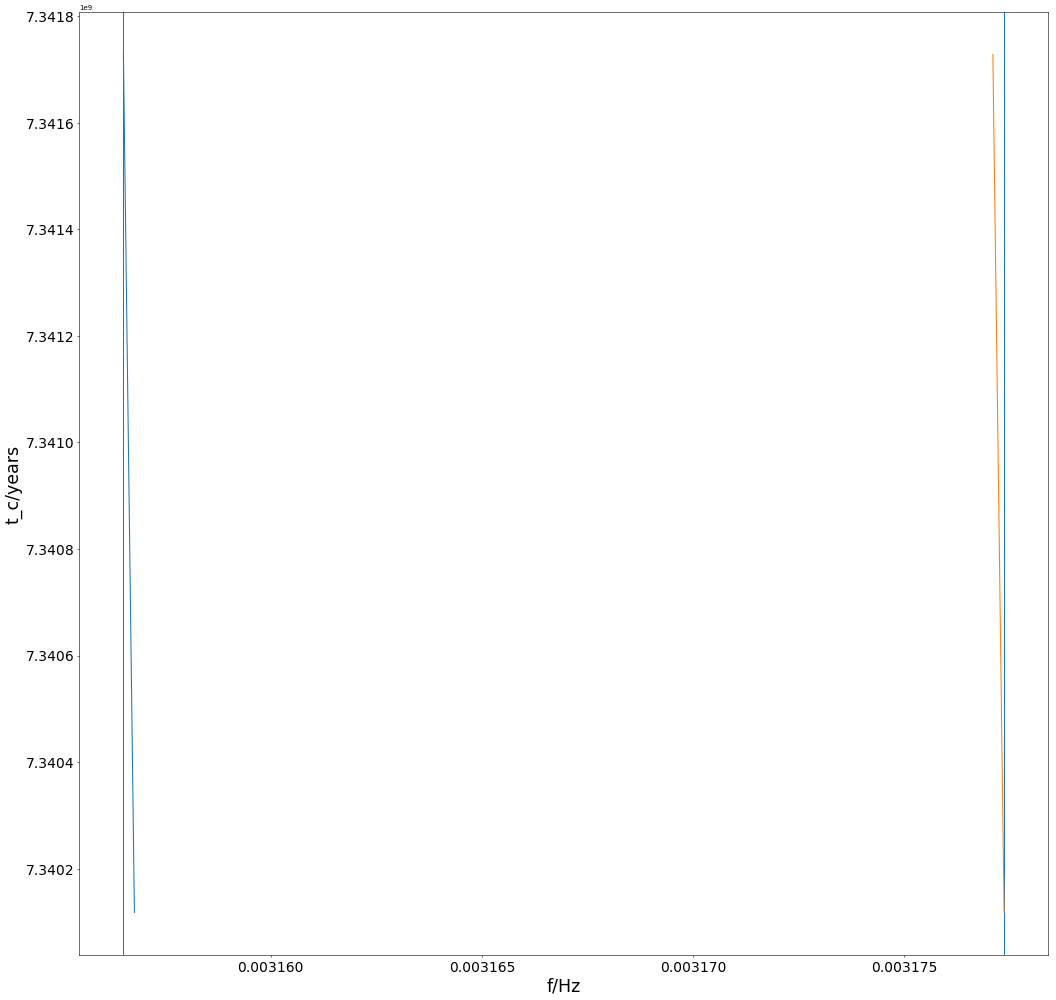

In [70]:
n=37
mc1=n*m_sun
m1=solvem(mc1,0.25)
print m1[0]/m_sun
fig1=plt.figure(figsize=(25,25),dpi=50)
tfj=np.linspace(tlimit(mc1,figas,ffgas)[0],tlimit(mc1,figas,ffgas)[1],10000)
plt.ylabel('t_c/years',fontsize=25)
plt.xlabel('f/Hz',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
yfj=f_jugg(tfj,m1[0],m1[1])
#print ((tlimit(mc1,figas,ffgas)[1]-tlimit(chirp_mass(n*m_sun,n*m_sun),figas,ffgas)[0])/tlimit(mc1,figas,ffgas)[1])//0.0001+1
plt.axvline(figas)
plt.axvline(ffgas)
plt.plot(yfj[0],tfj)
plt.plot(yfj[1],tfj)
#plt.plot(fint,work10/years)
#plt.plot(yfj[1]-yfj[0],tfj)
#plt.xscale('log')
plt.show()

In [56]:
m_sun

4.9270380555784728e-06

In [ ]:
def freq_faketgas(t,m_1,m_2,t_gas,t_0):
    a_ft=acalgas(t,m_1,m_2,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt((m_1+m_2)*np.power(a_ft,-1.5))

delf=freq_faketgas(t,m_1,m_2,t_gas,t_0)-freq_tgas(t,m_1,m_2,t_gas,t_0)

In [80]:
S_n_lisa(0.00316)

1.9022102881418837e-40

3.040488393684941e+23